# ABA: Recitation 4

### Spring 2024

In [1]:
# Import required libraries :
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats 
import statsmodels.formula.api as smf
from patsy import dmatrices

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Problem

We will focus on applying the Poisson regression model using the Affairs dataset. Our objective is to model the **number of affairs** reported by participants in the last year based on various covariates. The Affairs dataset contains 601 observations and 18 variables. The response variable, naffairs, indicates the number of affairs reported by participants in the past year. The other 17 variables are binary covariates representing different personal and marital attributes, such as:

- the presence of children (kids),
- happiness in marriage ,
- religiousness ,
- and years married. 

The dataset is used to model the count of affairs as a function of these covariates. We will use the sm.GLM function to build the model, prepare the data with dmatrices, and interpret the results to understand the relationships between different variables. 

# 2. Data

## Affairs dataset

### Description
Data from Fair (1978). Although Fair used a tobit model with the data, the outcome measure can be modeled as a count. In fact, Greene (2003) modeled it as Poisson, but given the amount of overdispersion in the data, employing a negative binomial model is an appropriate strategy. The data is stored in the `affairs` data set. `Naffairs` is the response variable, indicating the number of affairs reported by the participant in the past year.

Source: https://rdrr.io/cran/COUNT/man/affairs.html

### Format
A data frame with 601 observations on the following 18 variables.

- **naffairs**: number of affairs within last year
- **kids**: (1/0) 1=have children; 0=no children


- **vryunhap**: (1/0) very unhappily married
- **unhap**: (1/0) unhappily married
- **avgmarr**: (1/0) average married
- **hapavg**: (1/0) happily married
- **vryhap**: (1/0) very happily married


- **antirel**: (1/0) anti-religious
- **notrel**: (1/0) not religious
- **slghtrel**: (1/0) slightly religious
- **smerel**: (1/0) somewhat religious
- **vryrel**: (1/0) very religious


- **yrsmarr1**: (1/0) >0.75 yrs
- **yrsmarr2**: (1/0) >1.5 yrs
- **yrsmarr3**: (1/0) >4.0 yrs
- **yrsmarr4**: (1/0) >7.0 yrs
- **yrsmarr5**: (1/0) >10.0 yrs
- **yrsmarr6**: (1/0) >15.0 yrs



In [2]:
#read data
df_affairs = pd.read_csv('affairs.csv',index_col=0).reset_index(drop=True)

In [3]:
df_affairs

,naffairs,kids,vryunhap,unhap,avgmarr,hapavg,vryhap,antirel,notrel,slghtrel,smerel,vryrel,yrsmarr1,yrsmarr2,yrsmarr3,yrsmarr4,yrsmarr5,yrsmarr6
0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
2,3,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0
3,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
4,3,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
597,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
598,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
599,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1


#### Marriage status

In [4]:
#one hot encoding for marriage happiness
cols_to_group = ['vryunhap','unhap','avgmarr','hapavg','vryhap']
df_affairs.groupby(cols_to_group).size().to_frame('total').reset_index()

,vryunhap,unhap,avgmarr,hapavg,vryhap,total
0,0,0,0,0,1,232
1,0,0,0,1,0,194
2,0,0,1,0,0,93
3,0,1,0,0,0,66
4,1,0,0,0,0,16


In [5]:
# Using idxmax to find the column name where the value is 1 for each row
df_affairs['marital_status'] = df_affairs[cols_to_group].idxmax(axis=1)
df_affairs.groupby('marital_status').size().to_frame('total').reset_index()

,marital_status,total
0,avgmarr,93
1,hapavg,194
2,unhap,66
3,vryhap,232
4,vryunhap,16


#### Religious stance

In [6]:
#one hot encoding for religious stance
cols_to_group = ['antirel','notrel','slghtrel','smerel','vryrel']
df_affairs.groupby(cols_to_group).size().to_frame('total').reset_index()

,antirel,notrel,slghtrel,smerel,vryrel,total
0,0,0,0,0,1,70
1,0,0,0,1,0,190
2,0,0,1,0,0,129
3,0,1,0,0,0,164
4,1,0,0,0,0,48


In [7]:
df_affairs['religious_status'] = df_affairs[cols_to_group].idxmax(axis=1)
df_affairs.groupby('religious_status').size().to_frame('total').reset_index()

,religious_status,total
0,antirel,48
1,notrel,164
2,slghtrel,129
3,smerel,190
4,vryrel,70


#### years married

In [8]:
#one hot encoding for years married
cols_to_group = ['yrsmarr1','yrsmarr2','yrsmarr3','yrsmarr4','yrsmarr5','yrsmarr6']
df_affairs.groupby(cols_to_group).size().to_frame('total').reset_index()

,yrsmarr1,yrsmarr2,yrsmarr3,yrsmarr4,yrsmarr5,yrsmarr6,total
0,0,0,0,0,0,1,204
1,0,0,0,0,1,0,70
2,0,0,0,1,0,0,82
3,0,0,1,0,0,0,105
4,0,1,0,0,0,0,88
5,1,0,0,0,0,0,52


In [9]:
df_affairs['years_married'] = df_affairs[cols_to_group].idxmax(axis=1)
df_affairs.groupby('years_married').size().to_frame('total').reset_index()

,years_married,total
0,yrsmarr1,52
1,yrsmarr2,88
2,yrsmarr3,105
3,yrsmarr4,82
4,yrsmarr5,70
5,yrsmarr6,204


# 3. Plots

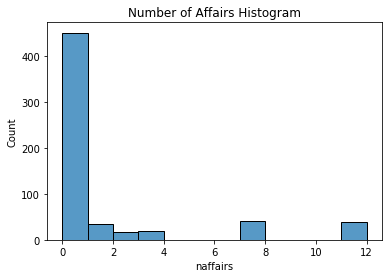

naffairs
0     451
1      34
2      17
3      19
7      42
12     38
dtype: int64

In [10]:
sns.histplot(df_affairs,x='naffairs',binwidth=1)
plt.title("Number of Affairs Histogram")
plt.show()
df_affairs.groupby('naffairs').size()

# OLS

We could try OLS, but, we know the data y is count data!

In [11]:
# Create the training and test data sets.
np.random.seed(42) #set random seed so we can recreate the results
mask = np.random.rand(len(df_affairs)) < 0.8
df_train = df_affairs[mask].reset_index(drop=True)
df_test = df_affairs[~mask].reset_index(drop=True)
print('Training data set length=' + str(len(df_train)))
print('Testing data set length=' + str(len(df_test)))

Training data set length=469
Testing data set length=132


In [12]:
# OLS
import statsmodels.formula.api as smf

# Define the regression model using a formula

expr_ols = """naffairs ~ vryunhap + unhap + hapavg + vryhap + 
antirel + notrel + smerel + vryrel + 
yrsmarr2 + yrsmarr3 + yrsmarr4 + yrsmarr5 + yrsmarr6 + 
kids"""
model = smf.ols(formula=expr_ols
                ,data=df_train)

# Fit the regression model
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               naffairs   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     7.583
Date:                Fri, 16 Feb 2024   Prob (F-statistic):           2.08e-14
Time:                        10:58:39   Log-Likelihood:                -1177.1
No. Observations:                 469   AIC:                             2384.
Df Residuals:                     454   BIC:                             2446.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3956      0.656      2.127      0.0

We can do predictions...

In [13]:
x_cov = ['vryunhap', 'unhap' , 'hapavg' , 'vryhap' , 
'antirel' , 'notrel' , 'smerel' , 'vryrel' , 
'yrsmarr2' , 'yrsmarr3' , 'yrsmarr4' , 'yrsmarr5' , 'yrsmarr6' , 
'kids']
y_pred = result.predict(exog=df_test[x_cov])

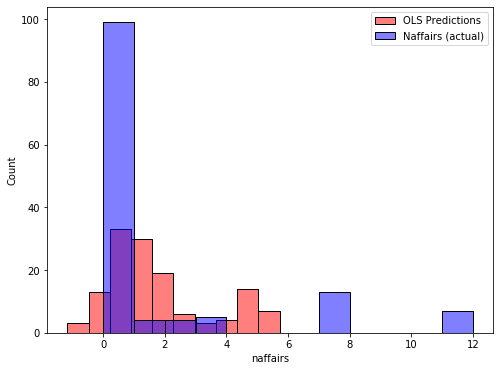

In [14]:
# Set up the Matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the 'poisson_predictions' histogram
sns.histplot( x=y_pred, color='red',  label='OLS Predictions', alpha=0.5)

# Plot the 'naffairs' histogram
sns.histplot(x=df_test.naffairs, color='blue', binwidth=1, label='Naffairs (actual)', alpha=0.5)

# Show the legend
plt.legend()

# Display the plot
plt.show()

Predicts negative affairs!

# 4. Poisson Model

#### Create the training and test data sets.

We'll fit the model in the training dataset, and then predict using the dataset

In [15]:
# Create the training and test data sets.
np.random.seed(42) #set random seed so we can recreate the results
mask = np.random.rand(len(df_affairs)) < 0.8
df_train = df_affairs[mask].reset_index(drop=True)
df_test = df_affairs[~mask].reset_index(drop=True)
print('Training data set length=' + str(len(df_train)))
print('Testing data set length=' + str(len(df_test)))

Training data set length=469
Testing data set length=132


#### Dmatrices

- The first one is a matrix of endogenous variable(s) (dependent variable): y_train, y_test
- The second is a matrix of exogenous variable(s) (i.e. independent, regressor, etc.): X_train, X_test

In [16]:
# Model 1
# Replace with your desired formula
#Using one-hot encoded (remove avgmarr, slghtrel, yrsmarr1)
expr1 = """naffairs ~ vryunhap + unhap + hapavg + vryhap + 
antirel + notrel + smerel + vryrel + 
yrsmarr2 + yrsmarr3 + yrsmarr4 + yrsmarr5 + yrsmarr6 + 
kids"""

y_train, X_train = dmatrices(expr1, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr1, df_test, return_type='dataframe')

#### Fit model

You are estimating a Poisson regression model with the following equation:

\begin{equation}
\log(\lambda) = \beta_0 + \beta_1 \cdot \text{vryunhap} + \beta_2 \cdot \text{unhap} + \beta_3 \cdot \text{hapavg} + \beta_4 \cdot \text{vryhap} + \beta_5 \cdot \text{antirel} + \beta_6 \cdot \text{notrel} + \beta_7 \cdot \text{smerel} + \beta_8 \cdot \text{vryrel} + \beta_9 \cdot \text{yrsmarr2} + \beta_{10} \cdot \text{yrsmarr3} + \beta_{11} \cdot \text{yrsmarr4} + \beta_{12} \cdot \text{yrsmarr5} + \beta_{13} \cdot \text{yrsmarr6} + \beta_{14} \cdot \text{kids}
\end{equation}

Where:

- $ \log(\lambda) $ is the natural logarithm of the expected count $ \lambda $ of `naffairs`.
- $ \beta_0, \beta_1, \ldots, \beta_{14} $ are the parameters to be estimated.


This is equivalent to:

\begin{equation}
\lambda = \lambda_0\exp\left(\beta_1 \cdot \text{vryunhap} + \beta_2 \cdot \text{unhap} + \beta_3 \cdot \text{hapavg} + \beta_4 \cdot \text{vryhap} + \beta_5 \cdot \text{antirel} + \beta_6 \cdot \text{notrel} + \beta_7 \cdot \text{smerel} + \beta_8 \cdot \text{vryrel} + \beta_9 \cdot \text{yrsmarr2} + \beta_{10} \cdot \text{yrsmarr3} + \beta_{11} \cdot \text{yrsmarr4} + \beta_{12} \cdot \text{yrsmarr5} + \beta_{13} \cdot \text{yrsmarr6} + \beta_{14} \cdot \text{kids}\right)
\end{equation}




A note in estimation:

Recall that the paramaters are found by maximizing the likelihood function (MLE).

For the entire dataset:

$$L(\mathbf{y}; \boldsymbol{\lambda}) = \prod_{i=1}^{n} \frac{e^{-\lambda_i} \lambda_i^{y_i}}{y_i!} $$

the overall log-likelihood for the entire dataset is the sum of the individual log-likelihoods for each observation:

$$\log L(\mathbf{y}; \boldsymbol{\lambda_i}) = \sum_{i=1}^{n} (-\lambda_i + y_i \log(\lambda_i) - \log(y_i!))$$

Where:
- $\mathbf{y}$ is the vector of observed counts.
- $\boldsymbol{\lambda}$ is the vector of expected counts modeled as a function of the predictors.


In [17]:
# Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results_1 = sm.GLM(endog=y_train
                                    ,exog=X_train
                                    ,family=sm.families.Poisson()).fit()
print(poisson_training_results_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               naffairs   No. Observations:                  469
Model:                            GLM   Df Residuals:                      454
Model Family:                 Poisson   Df Model:                           14
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1033.4
Date:                Fri, 16 Feb 2024   Deviance:                       1686.0
Time:                        10:58:40   Pearson chi2:                 2.98e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3586      0.281     -1.275      0.2

# 5. Poisson Regression Coefficients Interpretation

Considering 'avgmarr' for marriage happiness, 'slghtrel' for religiousness, and 'yrsmarr1' for years of marriage as the reference categories:

1. `vryunhap`
    - **Coefficient**: 0.6670
    - **Interpretation**: 
        The expected number of affairs increases by approximately $(e^{0.6670} - 1) \times 100 \approx 94.9\%$ for individuals who are very unhappy in their marriage compared to those with average marriage happiness, holding all else constant.

2. `unhap`
    - **Coefficient**: 1.0747
    - **Interpretation**: 
        Unhappy individuals experience a $(e^{1.0747} - 1) \times 100 \approx 193\%$ increase in the expected number of affairs compared to those with average marriage happiness, holding all else constant.

3. `hapavg`
    - **Coefficient**: -0.0784
    - **Interpretation**: 
        This variable is not statistically significant (p > 0.05), suggesting no strong evidence that it impacts the number of affairs compared to the reference category.

4. `vryhap`
    - **Coefficient**: -0.7988
    - **Interpretation**: 
        Very happily married individuals show a $(e^{-0.7988} - 1) \times 100 \approx -55\%$ decrease in the expected number of affairs compared to those with average marriage happiness, holding all else constant.

5. `antirel`
    - **Coefficient**: 0.4361
    - **Interpretation**: 
        Anti-religious individuals have a $(e^{0.4361} - 1) \times 100 \approx 54.7\%$ increase in the expected number of affairs compared to slightly religious individuals, holding all else constant.

6. `notrel`
    - **Coefficient**: -0.1418
    - **Interpretation**: 
        This variable is not statistically significant (p > 0.05), suggesting no strong evidence that it impacts the number of affairs compared to the reference category.

7. `smerel`
    - **Coefficient**: -0.8703
    - **Interpretation**: 
        Somewhat religious individuals show a $(e^{-0.8703} - 1) \times 100 \approx -58.4\%$ decrease in the expected number of affairs compared to slightly religious individuals, holding all else constant.

8. `vryrel`
    - **Coefficient**: -0.9438
    - **Interpretation**: 
        Very religious individuals show a $(e^{-0.9438} - 1) \times 100 \approx -60.9\%$ decrease in the expected number of affairs compared to slightly religious individuals, holding all else constant.

9. `yrsmarr2` to `yrsmarr6`
    - **Interpretation**: 
        Compared to those married for more than 0.75 to 1.5 years, individuals married for longer periods show generally an increase in the number of affairs. Note that `yrsmarr2` is not statistically significant.

10. `kids`
    - **Coefficient**: -0.2424
    - **Interpretation**: 
        Individuals with kids show a $(e^{-0.2424} - 1) \times 100 \approx -21.5\%$ decrease in the expected number of affairs compared to individuals without kids, holding all else constant.


The Deviance measure signals the goodness of fit of the model (similar to R^2), by comparing the predicted means to the actual values. Therefore, a lower value of deviance indicates a better fit. For our models, we have:

In [18]:
print(" Deviance of Model '%s' : %s" % (expr1,poisson_training_results_1.deviance))

 Deviance of Model 'naffairs ~ vryunhap + unhap + hapavg + vryhap + 
antirel + notrel + smerel + vryrel + 
yrsmarr2 + yrsmarr3 + yrsmarr4 + yrsmarr5 + yrsmarr6 + 
kids' : 1686.0098628659534


In [19]:
# # Model 1
# # Replace with your desired formula

# #marital_status + religious_status + years_married
# expr1 = 'naffairs ~ marital_status + religious_status + years_married + kids'

# y_train, X_train = dmatrices(expr1, df_train, return_type='dataframe')
# y_test, X_test = dmatrices(expr1, df_test, return_type='dataframe')

# # Using the statsmodels GLM class, train the Poisson regression model on the training data set.
# poisson_training_results_1 = sm.GLM(endog=y_train,
#                                     exog=X_train,
#                                     family=sm.families.Poisson()).fit()
# print(poisson_training_results_1.summary())

# 6. Predictions

The estimated expected count $\hat{\lambda}$ is calculated using the formula:

$$
\hat{\lambda} = e^{\beta_0 + \beta_1 \cdot \text{vryunhap} + \beta_2 \cdot \text{unhap} + \ldots + \beta_{14} \cdot \text{kids}}
$$

This is what poisson_training_results_1.predict(X) is computing. We will use X=X_test

In [20]:
X_test

,Intercept,vryunhap,unhap,hapavg,vryhap,antirel,notrel,smerel,vryrel,yrsmarr2,yrsmarr3,yrsmarr4,yrsmarr5,yrsmarr6,kids
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
128,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
129,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
130,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [21]:
#POISSON PREDICTIONS
poisson_predictions = poisson_training_results_1.predict(X_test)
y_test['poisson_predictions'] = poisson_predictions
y_test

,naffairs,poisson_predictions
0,0.0,0.730338
1,0.0,0.272784
2,0.0,3.470160
3,0.0,0.131648
4,0.0,1.187532
...,...,...
127,0.0,0.314338
128,0.0,0.573114
129,0.0,4.909612
130,0.0,0.808935


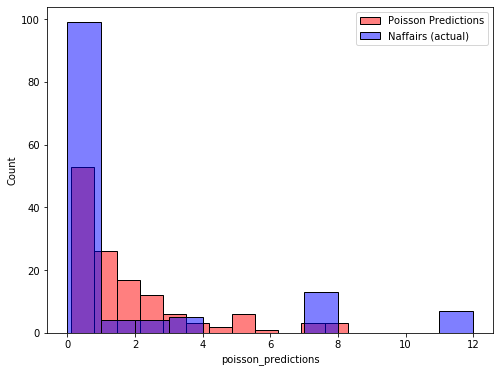

In [22]:
# Set up the Matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the 'poisson_predictions' histogram
sns.histplot(data=y_test, x='poisson_predictions', color='red', label='Poisson Predictions', alpha=0.5)

# Plot the 'naffairs' histogram
sns.histplot(data=y_test, x='naffairs', color='blue', binwidth=1, label='Naffairs (actual)', alpha=0.5)

# Show the legend
plt.legend()

# Display the plot
plt.show()

Set the bindwith to 1

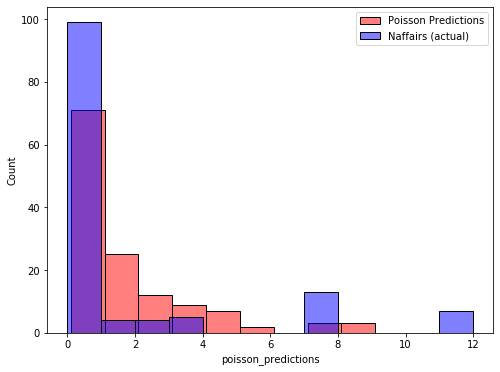

In [23]:
# Set up the Matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the 'poisson_predictions' histogram
sns.histplot(data=y_test, x='poisson_predictions', color='red', binwidth=1, label='Poisson Predictions', alpha=0.5)

# Plot the 'naffairs' histogram
sns.histplot(data=y_test, x='naffairs', color='blue', binwidth=1, label='Naffairs (actual)', alpha=0.5)

# Show the legend
plt.legend()

# Display the plot
plt.show()

# Better Predictions

- sample from the Poisson distribution

# Improving our model:

- Zero Inflated Poisson
- Negative Binomial Model